## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Прочитаем наш файл с исходными данными:

In [128]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Примечание. Загруженный нами датасет — это тренировочная часть, которую мы будем использовать для обучения и валидации моделей. Также есть отдельная тестовая часть, на которой мы будем оценивать итоговое качество нашей модели, но с этой частью датасета мы познакомимся на заключительном этапе проекта.

Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [129]:
# ваш код здесь
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Данные с 2016-01-01 по 2016-06-30

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [130]:
# ваш код здесь
cols_null_percent = taxi_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

In [131]:
# sns.heatmap(taxi_data.isnull()) # наглядная карта пропусков

## Пропусков в данных нет.

---

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [132]:
# ваш код здесь
import dtale
# d = dtale.show(taxi_data)
# d

Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы.

    → При дальнейшем анализе выяснится, что у нас также есть «телепортации» — поездки, которые были проделаны за секунды на большие расстояния. Но всему своё время.

Чтобы однозначно обозначить такие записи в таблице как выбросы, нам необходимо произвести более глубокий анализ данных с подключением дополнительной информации.

###  Примечание. На основе полученной статистической информации о целевом признаке trip_duration мы также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как [усечённое среднее](https://en.wikipedia.org/wiki/Truncated_mean), [логарифмическое среднее](https://apps.skillfactory.ru/learning/course/course-v1:SkillFactory+DSPR-2.0+14JULY2021/block-v1:SkillFactory+DSPR-2.0+14JULY2021+type@sequential+block@efac05ef68d14ea49b7f7b80de522138/block-v1:SkillFactory+DSPR-2.0+14JULY2021+type@vertical+block@a943813d55574a919f45cf7fd1130070) или медиана. При проведении исследований мы будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [133]:
# ваш код здесь
def add_datetime_features(df):
    # Проверяем, существует ли столбец 'pickup_datetime' в DataFrame
    if 'pickup_datetime' not in df.columns:
        raise ValueError("Исходный DataFrame не содержит столбец 'pickup_datetime'")

    # Преобразуем столбец 'pickup_datetime' в тип данных datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    # Добавляем столбец 'pickup_date' (дата без времени)
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # Добавляем столбец 'pickup_hour' (час дня)
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    # Добавляем столбец 'pickup_day_of_week' (день недели, начиная с понедельника)
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek

    return df


df = add_datetime_features(taxi_data)

In [134]:
num_rides = df.groupby('pickup_date')['id'].count()
print(f'Cреднее кол-во поездок в день: {num_rides.mean().round()}')

Cреднее кол-во поездок в день: 8015.0


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

* ### Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.

Давайте добавим в наш датасет информацию о том, является ли день праздничным. Для этого мы собрали даты всех праздничных дней в Америке за 2016 год. Данные представлены в табличном формате CSV и содержат три столбца:

* day — день недели;
* date — дата;
* holiday — наименование праздника.

In [135]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
# ваш код здесь
def add_holiday_features(trips_df, holidays_df):
    """
    Добавляет столбец is_holiday к таблице с данными о поездках.
    
    :param trips_df: DataFrame с данными о поездках, содержащий столбец 'pickup_date'.
    :param holidays_df: DataFrame с данными о праздничных днях, содержащий столбец 'holiday_date'.
    :return: Обновленный DataFrame с данными о поездках с добавленным столбцом 'pickup_holiday'.
    """
    
    # Преобразуем даты в datetime
    trips_df['pickup_date'] = pd.to_datetime(trips_df['pickup_date'])
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])

    # Создаем набор для быстрого поиска праздников
    holidays_set = set(holidays_df['date'])
    
    # Добавляем бинарный признак 'pickup_holiday'
    trips_df['is_holiday'] = trips_df['pickup_date'].apply(lambda x: 1 if x in holidays_set else 0)
    
    return trips_df

add_holiday_features(df, holiday_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,is_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,4,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,6,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,4,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,1,0


In [136]:
median_trip_duration_holiday = df[df['is_holiday'] == 1]['trip_duration'].median()
print(f'Медианное значение длительности поездки {median_trip_duration_holiday}')

Медианное значение длительности поездки 585.0


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [137]:
osrm_data = pd.read_csv('data/osrm_data_train.csv', sep=',')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


In [138]:
# ваш код здесь
def add_osrm_features(trips_df, osrm_df):
    # Выбираем интересующие столбцы из таблицы с данными из OSRM
    osrm_selected = osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    
    # Объединяем таблицы по столбцу 'id' с типом объединения left
    merged_df = trips_df.merge(osrm_selected, on='id', how='left')
    
    # Возвращаем обновленную таблицу с данными о поездках
    return merged_df


merged_df = add_osrm_features(df, osrm_data)

median_trip_duration = merged_df['trip_duration'].median()
median_trip_duration_osrm = merged_df['total_travel_time'].median(skipna=True)

print(f'A) Разница медианного значения длительности поездки с OSRM API: {(round(median_trip_duration - median_trip_duration_osrm))}')

A) Разница медианного значения длительности поездки с OSRM API: 372


## Примечание. Время поездки, вычисляемое с помощью OSRM, не является истинным временем поездки, так как оно вычисляется по кратчайшему пути при идеальных условиях: отсутствие пробок, погодных влияний и других внешних факторов. 

### Интересный факт. Если воспользоваться этим временем поездки как предсказанием, ваша ошибка прогноза будет довольно велика по сравнению с той, которую мы получим при использовании моделей машинного обучения.

In [139]:
# Проверим на наличие пропусков
cols_null_percent = merged_df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

total_distance       0.000069
total_travel_time    0.000069
number_of_steps      0.000069
dtype: float64

In [140]:
merged_df[merged_df.isnull().any(axis=1)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,is_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


In [141]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [142]:
# ваш код здесь
def get_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    EARTH_RADIUS = 6371  # радиус Земли в километрах
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

def add_geographical_features(df):
    df['haversine_distance'] = df.apply(lambda row: get_haversine_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df['direction'] = df.apply(lambda row: get_angle_direction(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    return df

In [143]:
df_coordinate = add_geographical_features(merged_df)

# Вопрос: Чему равно медианное расстояние по формуле гаверсинуса для поездок (в километрах)?
median_distance = df_coordinate['haversine_distance'].median()
print(f"Медианное расстояние по формуле гаверсинуса: {median_distance:.2f} км")

Медианное расстояние по формуле гаверсинуса: 2.09 км


In [144]:
df_coordinate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int32         
 13  pickup_day_o

---
### Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

## → Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

---

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [145]:
def add_cluster_features(taxi_data, n_clusters):
    # Создаем матрицу для кластеризации
    coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                        taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(coords)

    # Предсказываем кластеры
    geo_clusters = kmeans.predict(coords)
    
    # Добавляем столбец с кластерами в DataFrame
    taxi_data['geo_cluster'] = geo_clusters
    return taxi_data

df_coordinate = add_cluster_features(df_coordinate, 10)

cluster_counts = df_coordinate['geo_cluster'].value_counts()
print(cluster_counts)

# Находим наименьший по размеру кластер
min_cluster_size = cluster_counts.min()
print(f"Количество поездок в наименьшем по размеру географическом кластере: {min_cluster_size}")

geo_cluster
0    595850
6    405045
9    322999
7     45791
3     40671
2     32769
8     15510
4         4
5         3
1         2
Name: count, dtype: int64
Количество поездок в наименьшем по размеру географическом кластере: 2


Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

[Здесь](https://lms-cdn.skillfactory.ru/assets/courseware/v1/0f6abf84673975634c33b0689851e8cc/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/weather_data.zip) вы можете найти набор данных, содержащий информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

* time — дата измерения (с интервалом в час);
* temperature — температура;
* visibility — видимость;
* wind speed — средняя скорость ветра;
* precip — количество осадков;
* events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [146]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data.head(2)

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,NaN,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,NaN,Overcast,2015-12-31,3


In [147]:
# ваш код здесь
def add_weather_features(taxi_data, weather_data):
    taxi_data['pickup_date'] = pd.to_datetime(df_coordinate['pickup_datetime'], format='%Y-%m-%d').dt.date
    taxi_data['pickup_hour'] = pd.to_datetime(df_coordinate['pickup_datetime']).dt.hour

    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']
    weather_data['date'] = pd.to_datetime(weather_data['time']).dt.date
    weather_data['hour'] = pd.to_datetime(weather_data['time']).dt.hour
    
    merge_data = taxi_data.merge(
        weather_data[weather_cols],
        how = 'left',
        left_on = ['pickup_date', 'pickup_hour'],
        right_on = ['date', 'hour']
    )
    merge_data = merge_data.drop(['date', 'hour'], axis=1)
    
    return merge_data

taxi_data_updated = add_weather_features(df_coordinate, weather_data)

snow_trips = taxi_data_updated[taxi_data_updated['events'].str.contains('Snow', na=False)]
snow_trip_count = snow_trips.shape[0]
print(f"Количество поездок в снежную погоду: {snow_trip_count}")

# б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями?
total_trips = taxi_data_updated.shape[0]
missing_weather_data = taxi_data_updated.isnull().any(axis=1).sum()
missing_percentage = (missing_weather_data / total_trips) * 100

print(f"Процент записей с пропусками в погодных условиях: {missing_percentage:.2f}%")

Количество поездок в снежную погоду: 13126
Процент записей с пропусками в погодных условиях: 95.10%


In [148]:
taxi_data_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int32         
 13  pickup_day_o

In [149]:
cols_null_percent = taxi_data_updated.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

events               95.103192
temperature           0.824876
visibility            0.824876
wind speed            0.824876
precip                0.824876
total_distance        0.000069
total_travel_time     0.000069
number_of_steps       0.000069
dtype: float64

---

## Теперь, когда мы расширили датасет новыми признаками, нам необходимо немного его подчистить. О чём речь?

* В результате добавления новой информации у нас появились пропущенные значения в данных.
* Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.
---

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [150]:
taxi_data_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int32         
 13  pickup_day_o

In [151]:
# ваш код здесь
def fill_null_weather_data(data):
    # Преобразуем дату начала поездки в формат datetime
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['pickup_date'] = data['pickup_datetime'].dt.date
    
    # Список столбцов с погодными условиями
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    
    # Заполнение пропусков медианными значениями по дате начала поездки
    for col in weather_columns:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))
    
    # Заполнение пропусков в столбце events строкой 'None'
    data['events'] = data['events'].fillna('None')
    
    # Список столбцов с данными из OSRM API
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    
    # Заполнение пропусков медианными значениями по столбцам
    for col in osrm_columns:
        data[col] = data[col].fillna(data[col].median())
    
    return data

# Применяем функцию к данным о поездках
taxi_data_filled = fill_null_weather_data(taxi_data_updated)

# Вычисляем медиану в столбце temperature после заполнения пропусков
temperature_median = taxi_data_filled['temperature'].median()

print(f"Медиана в столбце temperature после заполнения пропусков: {temperature_median:.1f}")

Медиана в столбце temperature после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


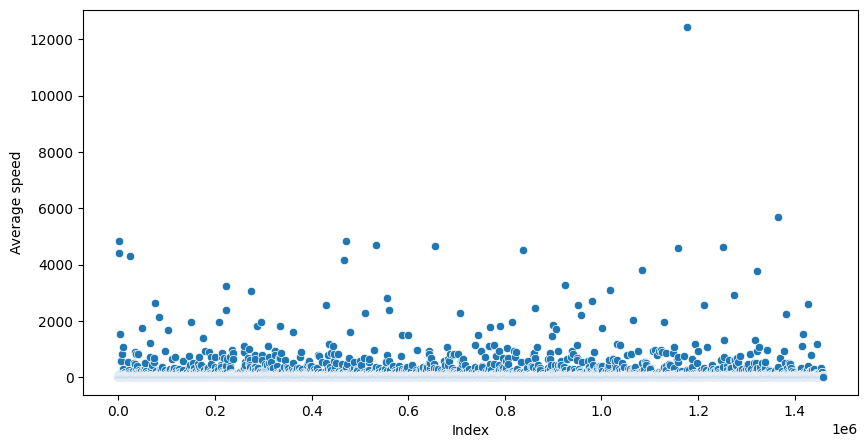

In [152]:
avg_speed = taxi_data_filled['total_distance'] / taxi_data_filled['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [153]:
taxi_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int32         
 13  pickup_day_o

In [154]:
# ваш код здесь
def identify_and_remove_outliers(data):
    # Преобразуем дату начала и окончания поездки в формат datetime
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
    
    # Вычислим длительность поездки в часах
    data['trip_duration_hours'] = data['trip_duration'] / 3600
    
    # Найдем поездки, длительность которых превышает 24 часа
    long_trip_outliers = data[data['trip_duration_hours'] > 24]
    
    # Удалим эти поездки из набора данных
    data = data[data['trip_duration_hours'] <= 24]
    
    # Вычислим среднюю скорость (в км/ч)
    data['average_speed_kmh'] = (data['total_distance'] / data['trip_duration']) * 3.6
    
    # Найдем поездки, средняя скорость которых превышает 300 км/ч
    speed_outliers = data[data['average_speed_kmh'] > 300]
    
    # Удалим эти поездки из набора данных
    data = data[data['average_speed_kmh'] <= 300]
    
    return data, len(long_trip_outliers), len(speed_outliers)


taxi_data_cleaned, num_long_trip_outliers, num_speed_outliers = identify_and_remove_outliers(taxi_data_updated)

print(f"Количество выбросов по признаку длительности поездки: {num_long_trip_outliers}")
print(f"Количество выбросов по признаку скорости: {num_speed_outliers}")

C:\Users\meleh\AppData\Local\Temp\ipykernel_21040\2136633643.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Количество выбросов по признаку длительности поездки: 4
Количество выбросов по признаку скорости: 407


In [155]:
taxi_data_cleaned = taxi_data_cleaned.drop(['average_speed_kmh', 'trip_duration_hours'], axis=1)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [156]:
taxi_data_cleaned['trip_duration_log'] = np.log(taxi_data_cleaned['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

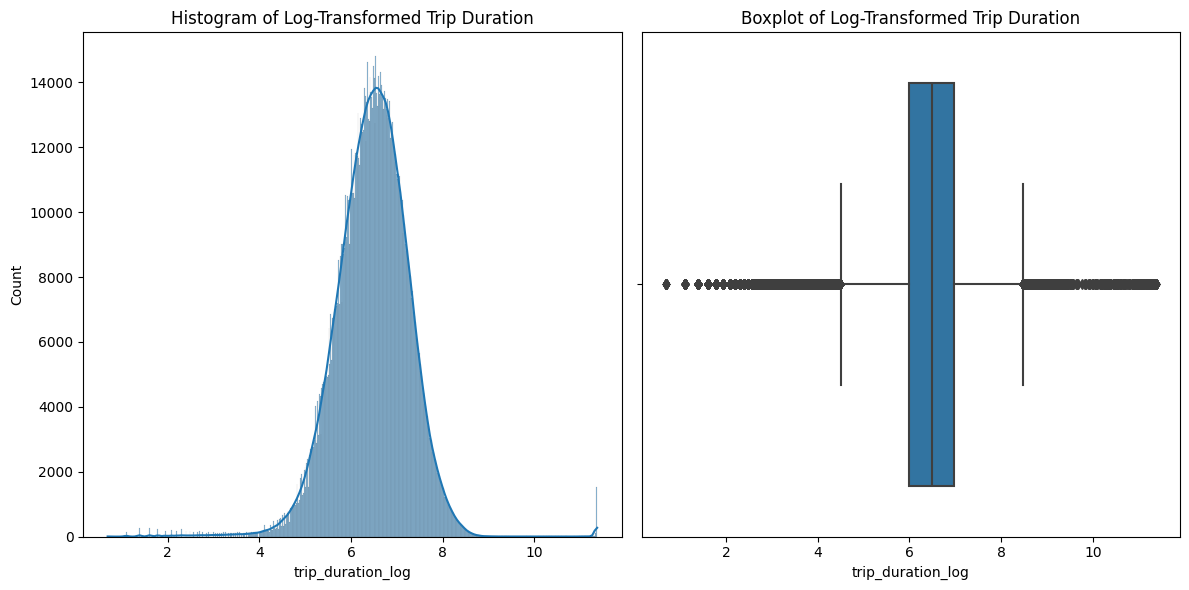

p-value: 0.00
Распределение не нормальное


In [157]:
# ваш код здесь
## Шаг 3. Построим гистограмму и коробчатую диаграмму
def gistogram_boxplot(log_data, col):
    plt.figure(figsize=(12, 6))

    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(log_data[col], kde=True)
    plt.title('Histogram of Log-Transformed Trip Duration')

    # Коробчатая диаграмма
    plt.subplot(1, 2, 2)
    sns.boxplot(x=log_data[col])
    plt.title('Boxplot of Log-Transformed Trip Duration')

    plt.tight_layout()
    plt.show()


from scipy.stats import normaltest
def Agustino_norm_test(log_data, col):
    # Проведение теста Д’Агостино
    stat, p_value = normaltest(log_data[col])

    # задаём уровень значимости
    alpha = 0.05 
    print(f'p-value: {p_value:.2f}')
    if p_value <= alpha:
        print('Распределение не нормальное')
    else:
        print('Распределение нормальное')
    


gistogram_boxplot(taxi_data_cleaned, 'trip_duration_log')
Agustino_norm_test(taxi_data_cleaned, 'trip_duration_log')


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

1. element='step':
    - Данный параметр определяет, как визуализировать сами стобцы гистограммы. Значение 'step' указывает на использование "шагов" (контуров), а не заполненных прямоугольников, для отображения гистограммы.

2. stat='density':
    - stat определяет вид статистики гистограммы. Значение 'density' нормирует гистограмму так, чтобы площадь под кривой равнялась 1 (плотность вероятности), а не просто счётчики (количественность) на каждую группу.

3. common_norm=False:
    - common_norm определяет, применять ли общую нормализацию для всех групп (при True) или нормализовать каждую группу отдельно (при False). 

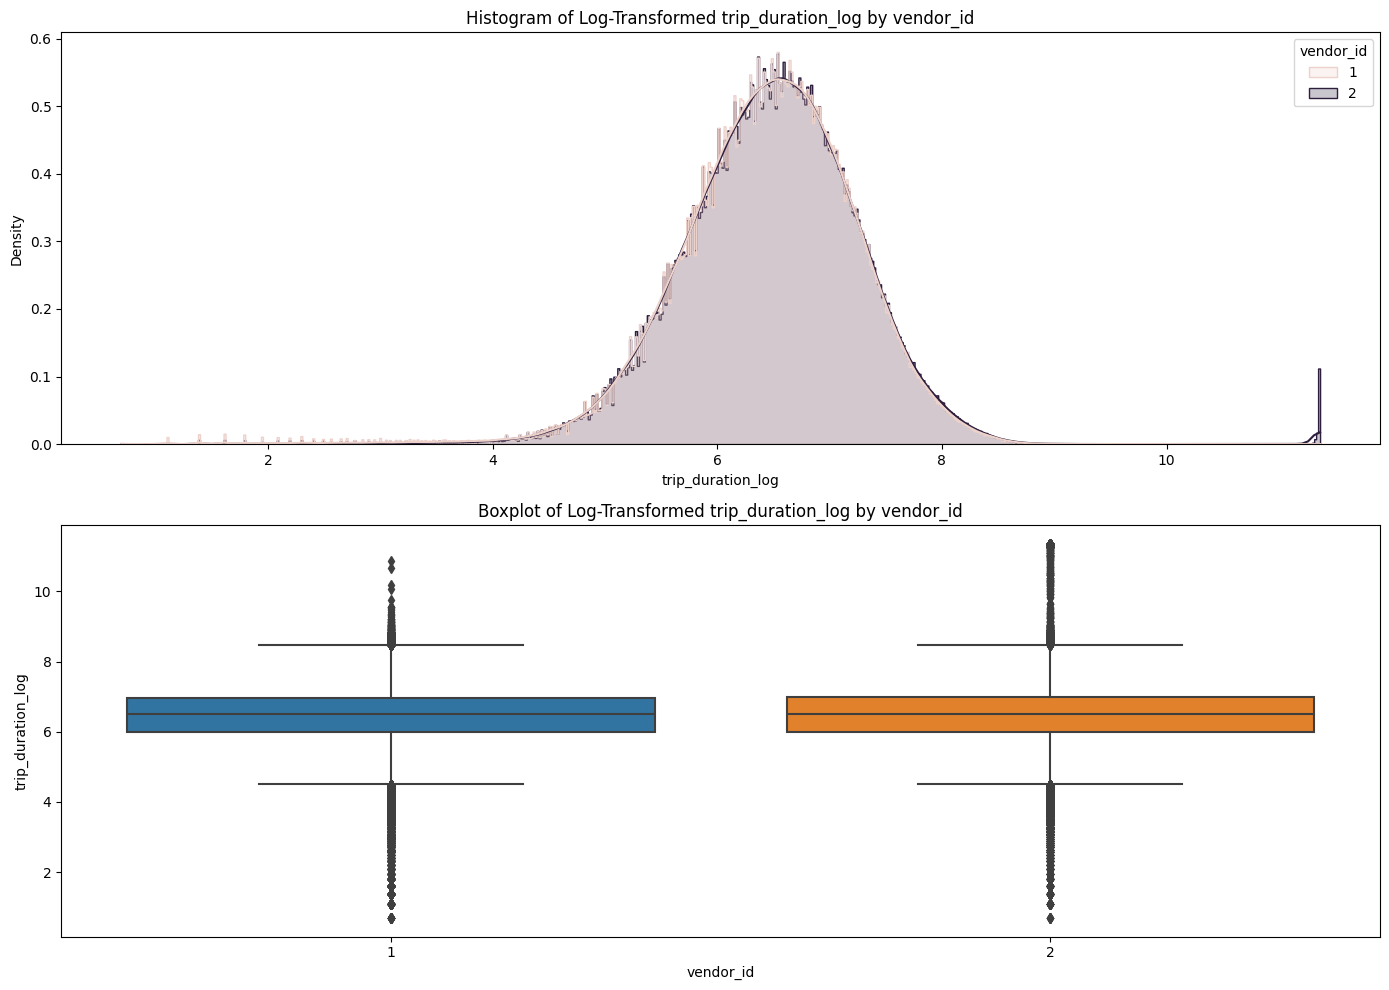

In [158]:
# ваш код здесь
def compare_cols(data, col1='trip_duration_log', col2='vendor_id'):
    plt.figure(figsize=(14, 10))

    # Гистограмма по группам vendor_id
    plt.subplot(2, 1, 1)
    sns.histplot(data, x=col1, hue=col2, kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Histogram of Log-Transformed {col1} by {col2}')

    # Коробчатые диаграммы по группам vendor_id
    plt.subplot(2, 1, 2)
    sns.boxplot(x=col2, y=col1, data=data)
    plt.title(f'Boxplot of Log-Transformed {col1} by {col2}')

    plt.tight_layout()
    plt.show()


compare_cols(taxi_data_cleaned)

Вывод: Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

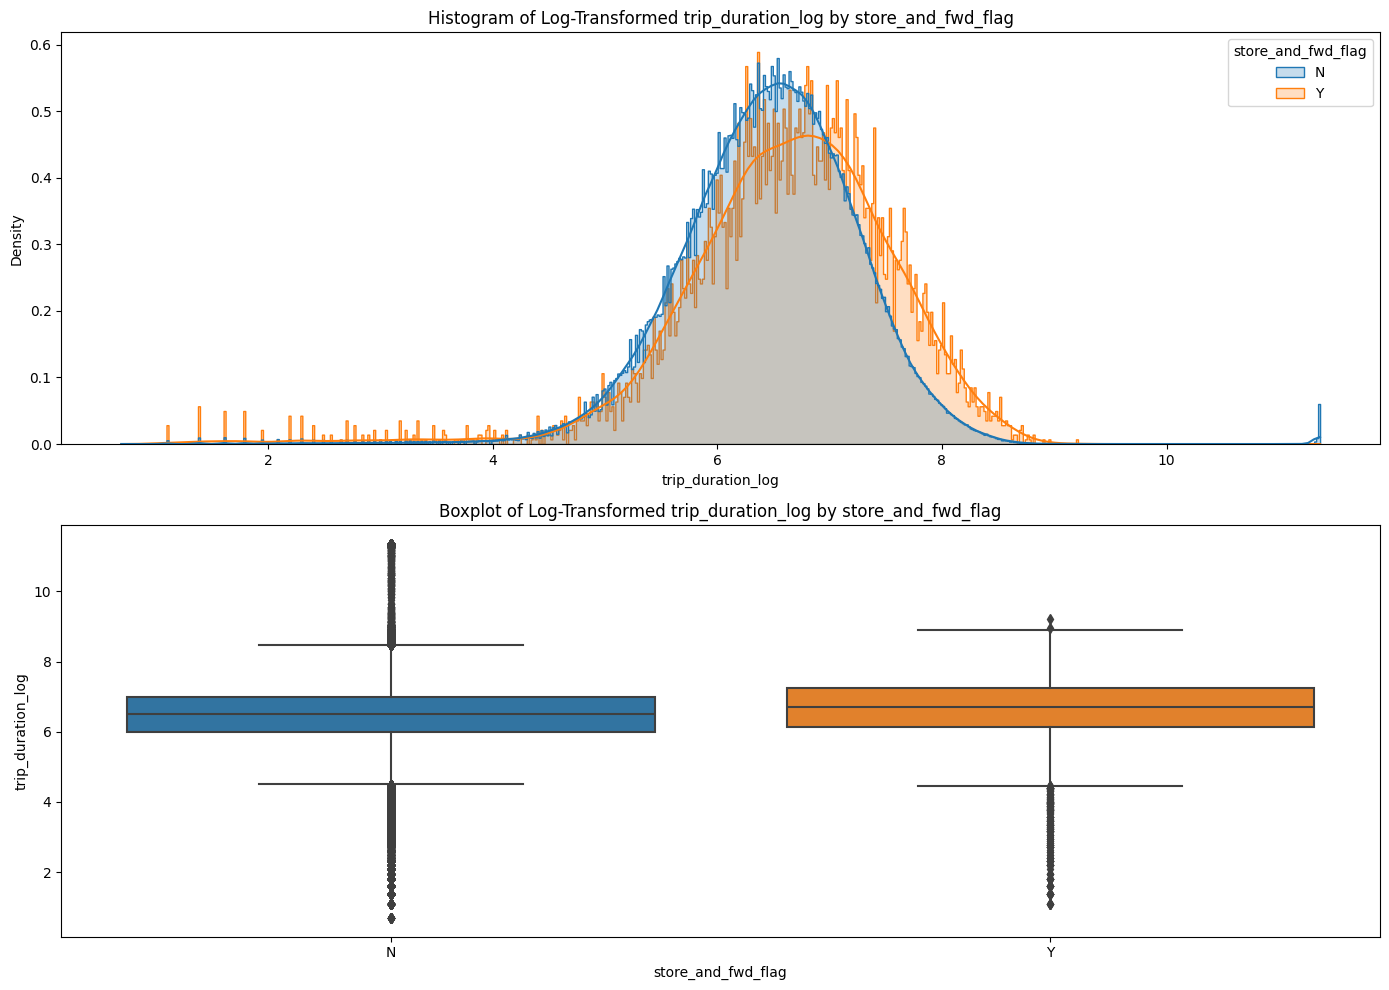

In [159]:
# ваш код здесь
compare_cols(taxi_data_cleaned, col2='store_and_fwd_flag')

### Вывод: Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

---
## Примечание. Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.
---

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [160]:
taxi_data_cleaned

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None,6.658011
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,11.0,6.049836,25.342196,6,7.2,2.8,18.5,8.1,Rain,6.486161
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,10.0,7.824606,-150.788492,9,18.3,16.1,0.0,0.0,None,6.639876
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None,5.924256


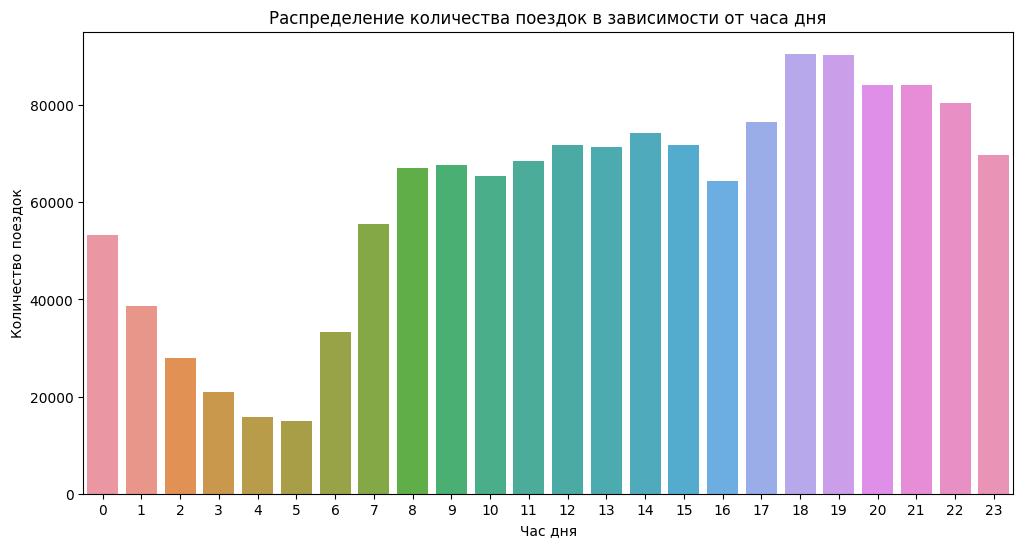

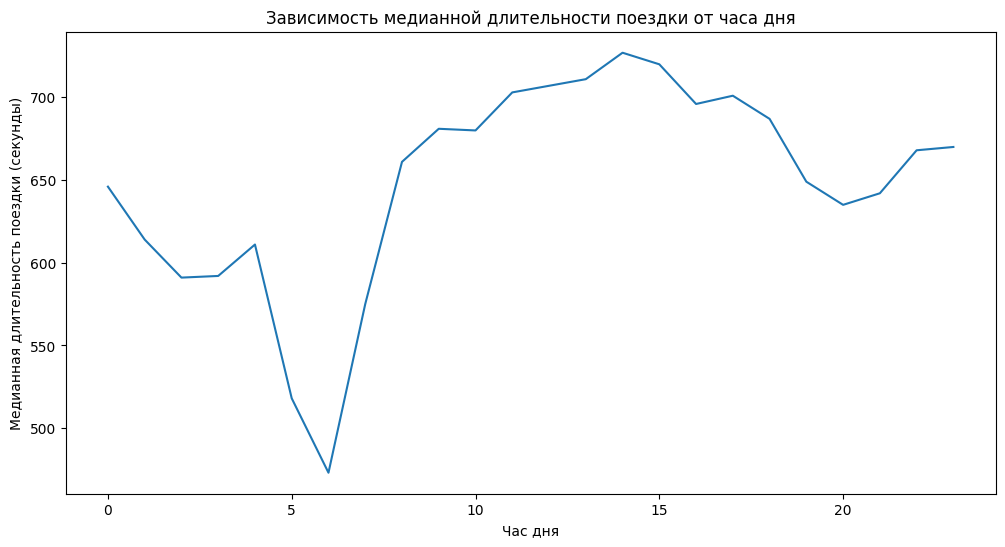

In [126]:
# ваш код здесь
def compare_trips_hours(df):
    df['hour_of_day'] = df['pickup_datetime'].dt.hour
    
    plt.figure(figsize=(12, 6))
    sns.countplot(x='hour_of_day', data=df)
    plt.title('Распределение количества поездок в зависимости от часа дня')
    plt.xlabel('Час дня')
    plt.ylabel('Количество поездок')
    plt.show()

    #    2. Зависимость медианной длительности поездки от часа дня
    hourly_median_duration = df.groupby('hour_of_day')['trip_duration'].median().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=hourly_median_duration, x='hour_of_day', y='trip_duration')
    plt.title('Зависимость медианной длительности поездки от часа дня')
    plt.xlabel('Час дня')
    plt.ylabel('Медианная длительность поездки (секунды)')
    plt.show()  
    
    df.drop('hour_of_day', axis=1, inplace=True)

    return df, hourly_median_duration

taxi_data_cleaned, hourly_median_duration = compare_trips_hours(taxi_data_cleaned)

In [37]:
trips_by_hour = taxi_data_cleaned['hour_of_day'].value_counts().sort_index()

# Найдём час с наименьшим количеством поездок
least_trips_hour = trips_by_hour.idxmin()
least_trips_count = trips_by_hour.min()

print(f"Время суток, когда такси заказывают реже всего: {least_trips_hour}:00")

peak_median_duration_hour = hourly_median_duration.loc[hourly_median_duration['trip_duration'].idxmax()]

print(f"Время суток, когда медианная длительность поездки максимально: {peak_median_duration_hour['hour_of_day']}:00")


Время суток, когда такси заказывают реже всего: 5:00
Время суток, когда медианная длительность поездки максимально: 14.0:00


### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


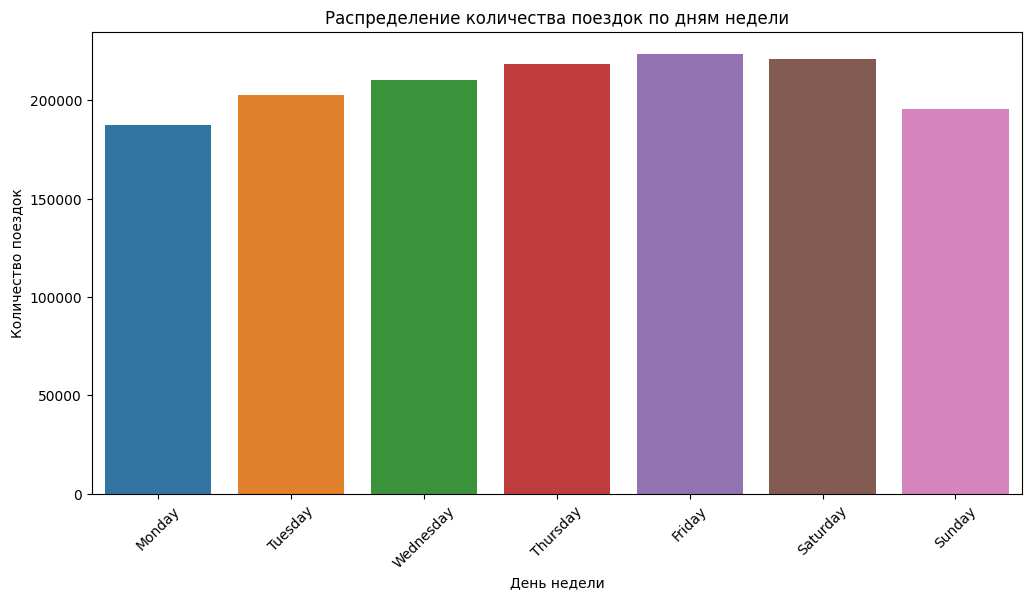

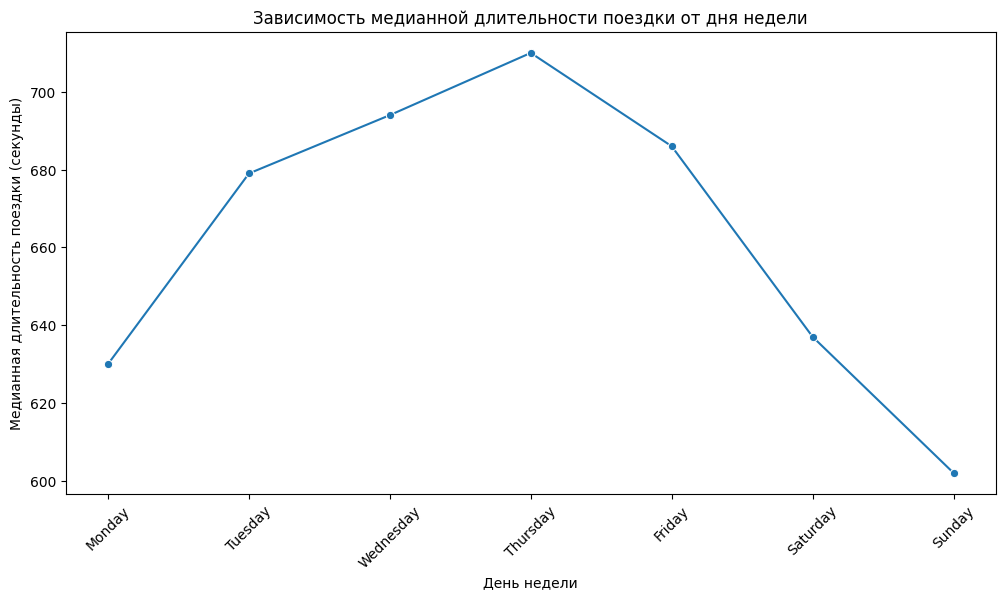

In [174]:
# ваш код здесь
def trips_per_weekday(df):
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # Дни недели: 0 - Понедельник, 6 - Воскресенье
    df['day_name'] = df['pickup_datetime'].dt.day_name()   # Конкретные названия дней недели

    # Для упорядочивания дней недели в графиках
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Построение графика распределения количества поездок по дням недели
    plt.figure(figsize=(12, 6))
    sns.countplot(x='day_name', data=df, order=order)
    plt.title('Распределение количества поездок по дням недели')
    plt.xlabel('День недели')
    plt.ylabel('Количество поездок')
    plt.xticks(rotation=45)
    plt.show()

    # Построение графика зависимости медианной длительности поездки от дня недели
    weekly_median_duration = df.groupby('day_name')['trip_duration'].median().reindex(order).reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=weekly_median_duration, x='day_name', y='trip_duration', marker='o')
    plt.title('Зависимость медианной длительности поездки от дня недели')
    plt.xlabel('День недели')
    plt.ylabel('Медианная длительность поездки (секунды)')
    plt.xticks(rotation=45)
    plt.show()

    df.drop(['day_of_week', 'day_name'], axis=1, inplace=True)

    return df, weekly_median_duration

taxi_data_cleaned, weekly_median_duration = trips_per_weekday(taxi_data_cleaned)    

In [39]:
most_trips_day = taxi_data_cleaned['day_name'].value_counts().idxmax()
most_trips_count = taxi_data_cleaned['day_name'].value_counts().max()

print(f"Наибольшее количество поездок совершается в {most_trips_day}, количество поездок: {most_trips_count}")

min_median_duration_day = weekly_median_duration.loc[weekly_median_duration['trip_duration'].idxmin()]

print(f"Наименьшая медианная длительность поездок в {min_median_duration_day['day_name']}, медианная длительность: {min_median_duration_day['trip_duration']} секунд")

Наибольшее количество поездок совершается в Friday, количество поездок: 223484
Наименьшая медианная длительность поездок в Sunday, медианная длительность: 602.0 секунд


### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

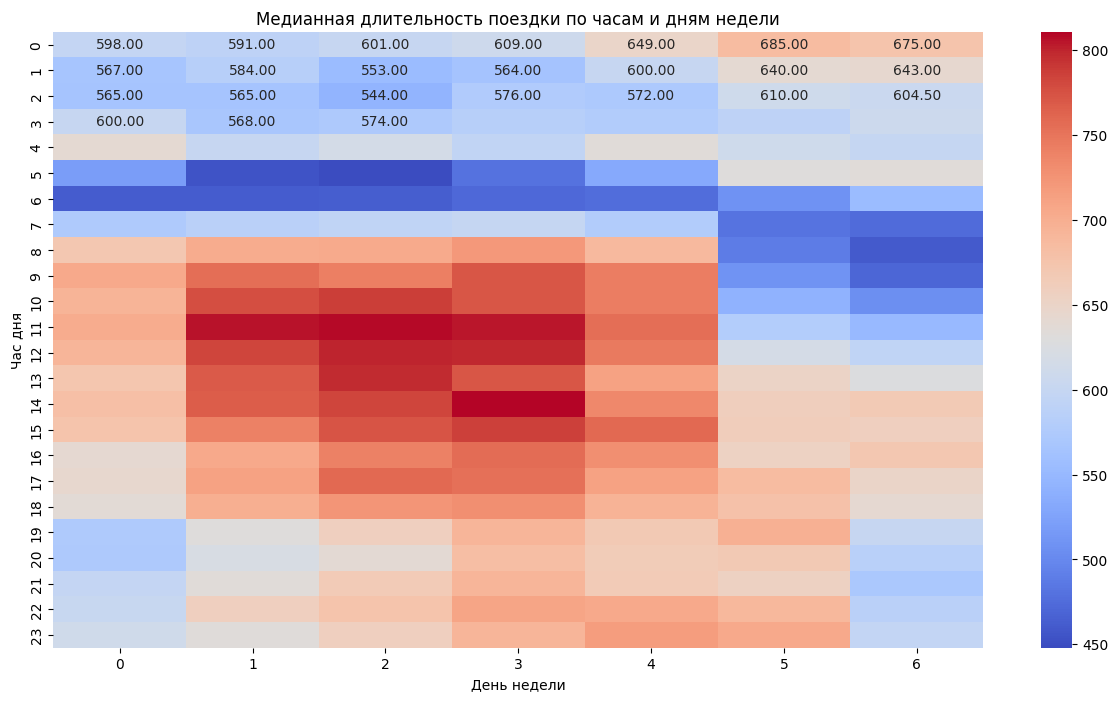

In [40]:
# ваш код здесь
def make_pivot_table(df):
    pivot_table = df.pivot_table(values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')

    # Визуализация с помощью тепловой карты
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Медианная длительность поездки по часам и дням недели")
    plt.xlabel("День недели")
    plt.ylabel("Час дня")
    plt.show()

make_pivot_table(taxi_data_cleaned)

Выводы: 
1. Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.
2. B Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


c:\Users\meleh\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



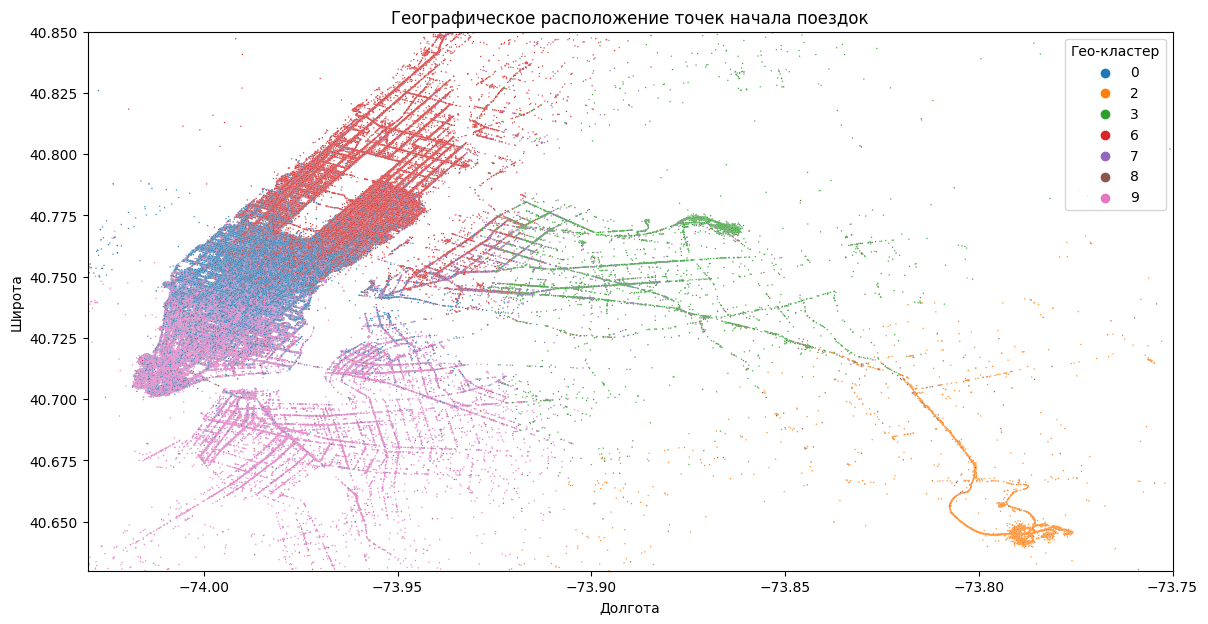

c:\Users\meleh\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



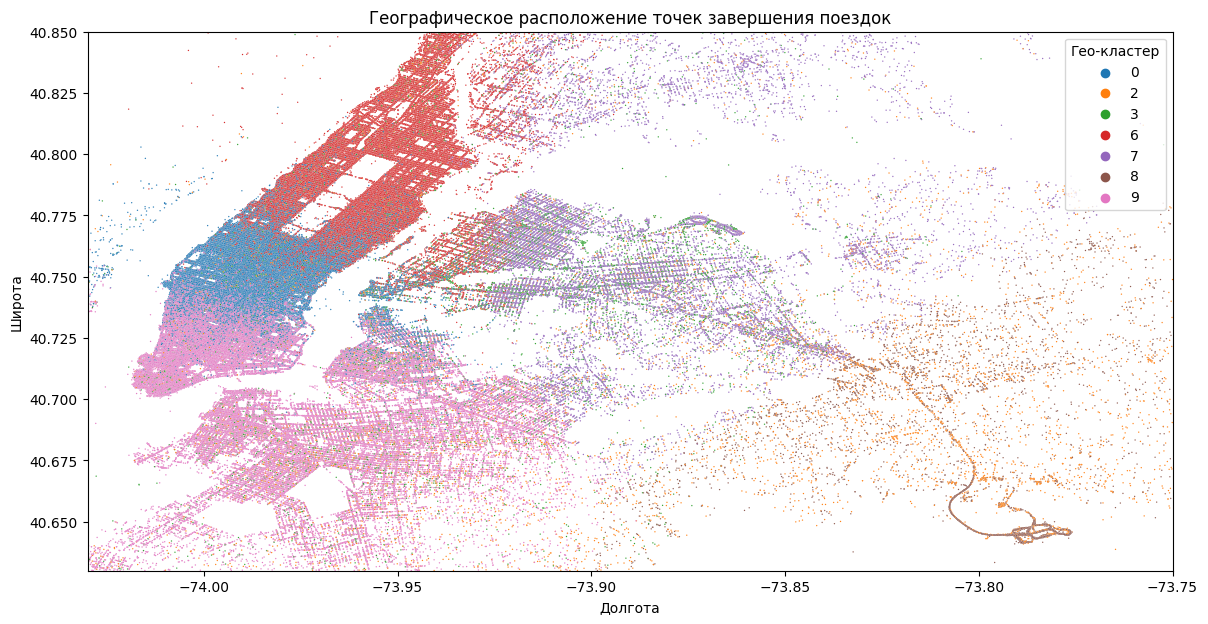

In [41]:
# ваш код здесь
def make_scatter_geo_clusters(df):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)

    #    Фильтрация данных по границам города
    pickup_within_city = df[
        (df['pickup_longitude'].between(city_long_border[0], city_long_border[1])) &
        (df['pickup_latitude'].between(city_lat_border[0], city_lat_border[1]))
    ]

    dropoff_within_city = df[
        (df['dropoff_longitude'].between(city_long_border[0], city_long_border[1])) &
        (df['dropoff_latitude'].between(city_lat_border[0], city_lat_border[1]))
    ]

    # Размер точек на scatter plot
    point_size = 1

    # Построение графика для точек начала поездок
    plt.figure(figsize=(14, 7))
    sns.scatterplot(
        x='pickup_longitude',
        y='pickup_latitude',
        hue='geo_cluster',
        data=pickup_within_city,
        palette='tab10',
        s=point_size,
        legend=True
    )
    plt.xlim(city_long_border)
    plt.ylim(city_lat_border)   
    plt.title("Географическое расположение точек начала поездок")
    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.legend(title='Гео-кластер')
    plt.show()

    # Построение графика для точек завершения поездок
    plt.figure(figsize=(14, 7))
    sns.scatterplot(
        x='dropoff_longitude',
        y='dropoff_latitude',
        hue='geo_cluster',
        data=dropoff_within_city,
        palette='tab10',
        s=point_size,
        legend=True
    )
    plt.xlim(city_long_border)
    plt.ylim(city_lat_border)
    plt.title("Географическое расположение точек завершения поездок")
    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.legend(title='Гео-кластер')
    plt.show()


make_scatter_geo_clusters(taxi_data_cleaned)

1. **Диаграмма расположения точек начала поездок:**

   
   **Анализ:**
   - **Центральная зона:** Большинство точек начала поездок сосредоточены в пределах Манхэттена, что видно по высокой плотности точек в этом районе. 
   - **Деловые районы:** Кластеры с высокой плотностью вероятно соответствуют деловым и коммерческим районам, как Wall Street и Midtown Manhattan.
   - **Аэропорты:** Наличие кластеров с высокой плотностью около аэропортов (JFK и LaGuardia) также заметно.
   - **Жилые районы:** Меньше точек начала поездок на окраинах, что может свидетельствовать о более низкой частоте использования такси в этих районах.

2. **Диаграмма расположения точек завершения поездок:**
   
   **Анализ:**
   - **Похожие паттерны:** Распределение точек завершения также показывает концентрацию в Манхэттене и вокруг деловых районов, что может указывать на рабочие поездки.
   - **Жилые и туристические зоны:** Повышенная плотность точек завершения в туристических зонах, таких как Times Square.
   - **Аэропорты:** Заметное число точек завершения поездок возле аэропортов, что может свидетельствовать о частых выездах к этим местам.

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [42]:
print('Shape of data: {}'.format(taxi_data_cleaned.shape))
print('Columns: {}'.format(taxi_data_cleaned.columns))

Shape of data: (1458233, 30)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'is_holiday', 'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'direction', 'geo_cluster', 'temperature',
       'visibility', 'wind speed', 'precip', 'events', 'trip_duration_log',
       'hour_of_day', 'day_of_week', 'day_name'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [175]:
train_data = taxi_data_cleaned.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?
- id
б) Утечка данных (data leak) - это…
- ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.
в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?
- dropoff_datetime
г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?

д) Исключите повторяющиеся признаки (н-р: day_of_week и day_name)

In [177]:
# ваш код здесь
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
train_data.head(3)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [178]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [179]:
# ваш код здесь
train_data['vendor_id'] = train_data['vendor_id'].replace({1: 0, 2: 1})
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].replace({'N': 0, 'Y': 1})

# Рассчитываем среднее по закодированному столбцу vendor_id
mean_vendor_id = train_data['vendor_id'].mean()

# Выводим результат
print(f"Среднее по закодированному столбцу vendor_id: {mean_vendor_id:.2f}")

mean_store_and_fwd_flag = train_data['store_and_fwd_flag'].mean()

# Выводим результат
print(f"Среднее по закодированному столбцу store_and_fwd_flag: {mean_store_and_fwd_flag:.3f}")

Среднее по закодированному столбцу vendor_id: 0.53
Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [180]:
# ваш код здесь
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

train_data = pd.DataFrame(train_data)

# Создаем OneHotEncoder с нужными параметрами
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Кодируем категориальные признаки
encoded_features = one_hot_encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']])

# Получаем имена закодированных столбцов
column_names = one_hot_encoder.get_feature_names_out()

# Преобразуем закодированные признаки обратно в DataFrame
data_onehot = pd.DataFrame(encoded_features.toarray(), columns=column_names)

# Выводим результат
data_onehot.reset_index(drop=True, inplace=True)
print(data_onehot)


         pickup_day_of_week_1  pickup_day_of_week_2  pickup_day_of_week_3  \
0                         0.0                   0.0                   0.0   
1                         0.0                   0.0                   0.0   
2                         1.0                   0.0                   0.0   
3                         0.0                   1.0                   0.0   
4                         0.0                   0.0                   0.0   
...                       ...                   ...                   ...   
1458228                   0.0                   0.0                   0.0   
1458229                   0.0                   0.0                   0.0   
1458230                   0.0                   0.0                   0.0   
1458231                   1.0                   0.0                   0.0   
1458232                   1.0                   0.0                   0.0   

         pickup_day_of_week_4  pickup_day_of_week_5  pickup_day_of_week_6  

Добавим полученную таблицу с закодированными признаками:

In [181]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [182]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

    Примечание. Тестовая выборка, с которой мы познакомимся позднее, представлена отдельным датасетом. Истинные длительности поездок из тестового набора являются для нас неизвестными, и финальное качество модели можно узнать, только сделав предсказание и отправив файл с предсказанием на проверку на платформе Kaggle.

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [183]:
# ваш код здесь
from sklearn.feature_selection import SelectKBest, f_regression
# Используем SelectKBest для отбора лучших признаков
selector = SelectKBest(score_func=f_regression, k=25)
X_new = selector.fit_transform(X, y)

# Получаем имена отобранных признаков
selected_features = X.columns[selector.get_support()]

# Выводим имена отобранных признаков
print(selected_features)

work_data = train_data[selected_features]

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'is_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_2',
       'geo_cluster_3', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8',
       'geo_cluster_9'],
      dtype='object')


In [184]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    work_data, y_log, 
    test_size=0.33, 
    random_state=42
)

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. 

---
#### Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!
---
Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [185]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'is_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_2',
       'geo_cluster_3', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8',
       'geo_cluster_9'],
      dtype='object')

In [186]:
# ваш код здесь
from sklearn.preprocessing import MinMaxScaler

# Примерные данные (нужно заменить на реальные данные)
# X_train и X_valid должны содержать предикторы из обучающей и валидационной выборок соответственно

# Инициализация MinMaxScaler
mm_scaler = MinMaxScaler()

# Обучаем нормализатор на обучающей выборке
mm_scaler.fit(X_train)

# Трансформируем обучающую и валидационную выборки
X_train_scaled = mm_scaler.transform(X_train)
X_valid_scaled = mm_scaler.transform(X_valid)

# Рассчитываем среднее арифметическое для первого предиктора из валидационной выборки
mean_first_predictor = np.mean(X_valid_scaled[:, 0])

# Округляем результат до сотых
mean_first_predictor_rounded = round(mean_first_predictor, 2)

# Выводим результат
print(mean_first_predictor_rounded)

0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [53]:
from sklearn.metrics import mean_squared_log_error

# Построим модель линейной регрессии
model = linear_model.LinearRegression()
model.fit(X_train_scaled, y_train_log)

# Предсказания модели
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)

# Рассчитываем RMSLE
print('rsmle_train:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('rsmle_train:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

rsmle_train: 0.53
rsmle_train: 0.54


In [54]:
y_train_pred

array([5.9331044 , 6.12151993, 5.90519305, ..., 6.32275284, 5.9412701 ,
       6.22673153])

### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [64]:
# ваш код здесь
# Генерируем полиномиальные признаки второй степени
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# Нормализуем признаки
scaler = preprocessing.MinMaxScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_valid_poly = scaler.transform(X_valid_poly)

# Построим модель линейной регрессии
model = linear_model.LinearRegression()
model.fit(X_train_poly, y_train_log)

# Предсказания модели
y_train_pred = model.predict(X_train_poly)
y_val_pred = model.predict(X_valid_poly)

# Рассчитываем RMSLE
print('rsmle_train:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('rsmle_train:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

rsmle_train: 0.46
rsmle_train: 0.54


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# Построим модель линейной регрессии
ridge_model = linear_model.Ridge(alpha=1, random_state=42)
ridge_model.fit(X_train_poly, y_train_log)

# Предсказания модели
y_train_pred = ridge_model.predict(X_train_poly)
y_val_pred = ridge_model.predict(X_valid_poly)

# Рассчитываем RMSLE
print('rsmle_train:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('rsmle_train:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

NameError: name 'linear_model' is not defined

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# ваш код здесь
dt_model = tree.DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_poly, y_train_log)

# Предсказания модели
y_train_pred = dt_model.predict(X_train_poly)
y_valid_pred = dt_model.predict(X_valid_poly)

# Рассчитываем RMSLE
print('rsmle_train:', round(metrics.mean_squared_error(y_train_log, y_train_pred)**.5, 2))
print('rsmle_train:', round(metrics.mean_squared_error(y_valid_log, y_valid_pred)**.5, 2))

rsmle_train: 0.0
rsmle_train: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
def max_depth_selection(X, y, X_v, y_v):
  rmsle_train = {}
  rmsle_valid = {}
  for i in range(7, 20, 1):
    dtr=tree.DecisionTreeRegressor(max_depth=i, random_state=42)
    dtr.fit(X, y)
    y_train_predict_dt=dtr.predict(X)
    y_valid_predict_dt=dtr.predict(X_v)
    rmsle_train[i] = np.sqrt(metrics.mean_squared_error(y, y_train_predict_dt))
    rmsle_valid[i] = np.sqrt(metrics.mean_squared_error(y_v, y_valid_predict_dt))

  return rmsle_train, rmsle_valid

rmsle_train, rmsle_valid = max_depth_selection(X_train_poly, y_train_log, X_valid_poly, y_valid_log)

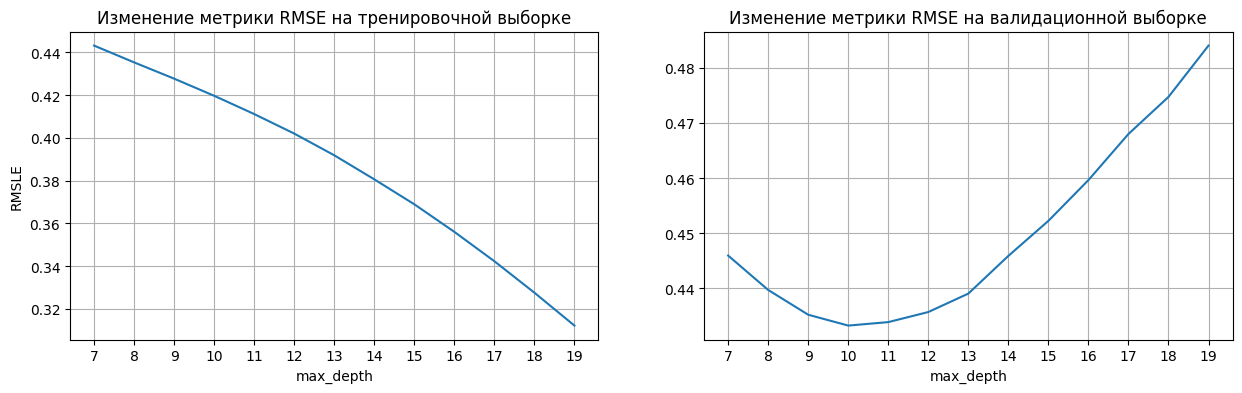

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.lineplot(rmsle_train, ax=axes[0])
axes[0].set_title('Изменение метрики RMSE на тренировочной выборке')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('RMSLE')
axes[0].grid()
axes[0].set_xticks(range(7,20,1));

sns.lineplot(rmsle_valid, ax=axes[1])
axes[1].set_title('Изменение метрики RMSE на валидационной выборке')
axes[1].set_xlabel('max_depth')
axes[1].grid()
axes[1].set_xticks(range(7,20,1));

In [ ]:
dtr=tree.DecisionTreeRegressor(max_depth=11, random_state=42)
dtr.fit(X_train_poly, y_train_log)
y_train_predict_dt=dtr.predict(X_train_poly)
y_valid_predict_dt=dtr.predict(X_valid_poly)

print('Best RSMLE score on training data {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_dt))))
print('Best RSMLE score on validtion data {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict_dt))))

Best RSMLE score on training data 0.41
Best RSMLE score on validtion data 0.43


In [ ]:
param_grid = {'max_depth':list(range(7, 20, 1))}

grid_search = model_selection.GridSearchCV(estimator=tree.DecisionTreeRegressor(random_state=42), param_grid=param_grid, n_jobs=-1, verbose=True)
grid_search.fit(X_train_scaled, y_train_log)
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
y_train_predict = grid_search.predict(X_train_scaled)
print('RMSLE на тренировочном наборе: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict))))
y_valid_predict = grid_search.predict(X_valid_scaled)
print('RMSLE на валидационном наборе: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict))))

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Наилучшие значения параметров: {'max_depth': 11}
RMSLE на тренировочном наборе: 0.41
RMSLE на валидационном наборе: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [57]:
# ваш код здесь
# Создаем модель случайного леса
rf_model = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True
)

# Обучаем модель
rf_model.fit(X_train_poly, y_train_log)

# Предсказания
y_train_pred = rf_model.predict(X_train_poly)
y_val_pred = rf_model.predict(X_valid_poly)

# Рассчитываем метрику RMSLE
train_rmsle = np.sqrt(mean_squared_log_error(y_train_log, y_train_pred))
val_rmsle = np.sqrt(mean_squared_log_error(y_valid_log, y_val_pred))

print(f"RMSLE на тренировочной выборке: {train_rmsle:.2f}")
print(f"RMSLE на валидационной выборке: {val_rmsle:.2f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  5.0min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 20.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   17.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s


RMSLE на тренировочной выборке: 0.06
RMSLE на валидационной выборке: 0.06


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.4s


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [58]:
# ваш код здесь
# Создаем модель градиентного бустинга
gbr_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)

# Обучаем модель
gbr_model.fit(X_train_poly, y_train_log)

# Предсказания
y_train_pred = gbr_model.predict(X_train_poly)
y_val_pred = gbr_model.predict(X_valid_poly)

# Рассчитываем метрику RMSLE
train_rmsle = np.sqrt(mean_squared_log_error(y_train_log, y_train_pred))
val_rmsle = np.sqrt(mean_squared_log_error(y_valid_log, y_val_pred))

print(f"RMSLE на тренировочной выборке: {train_rmsle:.2f}")
print(f"RMSLE на валидационной выборке: {val_rmsle:.2f}")

      Iter       Train Loss   Remaining Time 
         1           0.3110            8.08m
         2           0.2246            8.02m
         3           0.1984            7.90m
         4           0.1876            7.78m
         5           0.1825            7.73m
         6           0.1793            7.64m
         7           0.1761            7.59m
         8           0.1740            7.56m
         9           0.1718            7.52m
        10           0.1706            7.49m
        20           0.1606           10.46m
        30           0.1543           10.07m
        40           0.1512            8.25m
        50           0.1480            7.02m
        60           0.1452            5.30m
        70           0.1433            3.73m
        80           0.1420            2.37m
        90           0.1402            1.14m
       100           0.1388            0.00s
RMSLE на тренировочной выборке: 0.05
RMSLE на валидационной выборке: 0.06


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [ ]:
# ваш код здесь
gb_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)

# Обучаем модель
gb_model.fit(X_train_scaled, y_train_log)

# Получение значимости факторов
feature_importance = gb_model.feature_importances_

Length of feature_names: 350
Length of feature_importance: 350


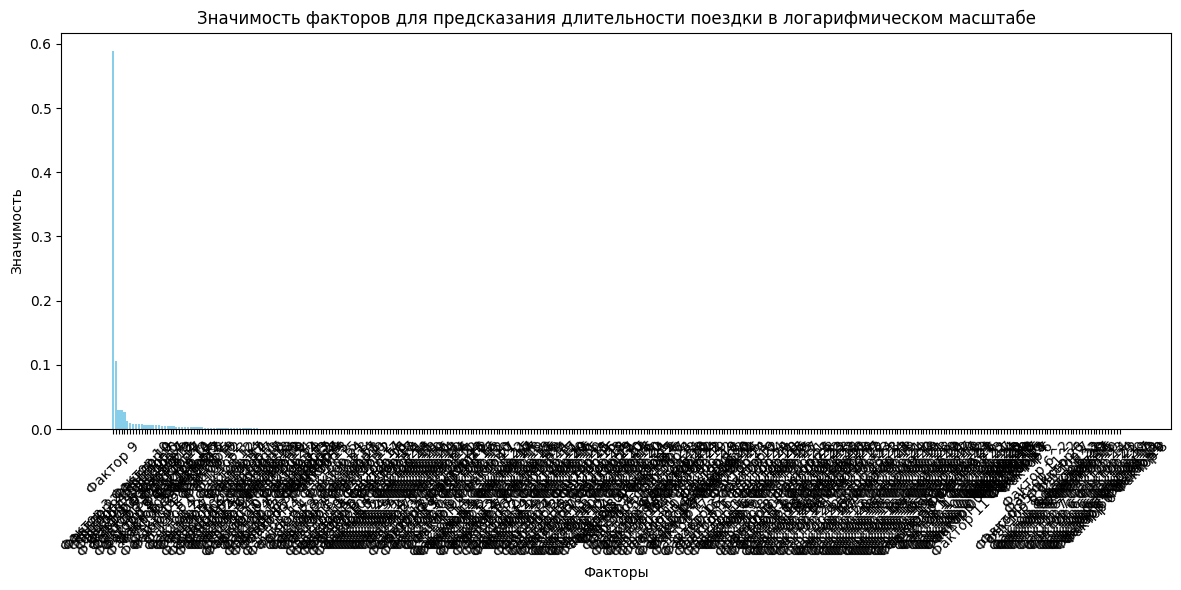

In [69]:
# Получение имен полиномиальных признаков
feature_names = gb_model.get_feature_names_out(input_features=[f'Фактор {i}' for i in range(len(selected_features))])

# Создание DataFrame для удобства
importance_df = pd.DataFrame({'Фактор': feature_names, 'Важность': feature_importance})

# Сортировка по значимости
importance_sorted = importance_df.sort_values(by='Важность', ascending=False)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
plt.bar(importance_sorted['Фактор'], importance_sorted['Важность'], color='skyblue')
plt.xlabel('Факторы')
plt.ylabel('Значимость')
plt.title('Значимость факторов для предсказания длительности поездки в логарифмическом масштабе')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [70]:
y_valid_pred_log = gb_model.predict(X_valid_poly)
y_valid_pred = np.exp(y_valid_pred_log) - 1
y_valid_real = np.exp(y_valid_log) - 1

from sklearn.metrics import median_absolute_error as mae

MeAE = mae(y_valid_real, y_valid_pred) / 60
print(f"MeAE on valid: {round(MeAE, 1)}")

MeAE on valid: 1.9


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [187]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [188]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, n_clusters=10)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)
test_data = test_data.drop(['pickup_datetime', 'pickup_date'], axis=1)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

In [189]:
test_data.drop(['id'], axis=1, inplace=True)

In [190]:
test_data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'is_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'temperature',
       'visibility', 'wind speed', 'precip', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_1',
       'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4', 'geo_cluster_5',
       'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9',
       'events_Rain', 'events_Snow'],
      dtype='object')

In [191]:
X_test = test_data[selected_features]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [210]:
X_test_poly = poly.transform(X_test_scaled)
X_test_poly.shape[1]

350

In [211]:
y_test_pred = gb_model.predict(X_test_poly)
y_test_orig = np.expm1(y_test_pred)

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [197]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 1.3 MB/s eta 0:01:38
   ---------------------------------------- 0.1/124.9 MB 1.3 MB/s eta 0:01:36
   ---------------------------------------- 0.2/124.9 MB 1.4 MB/s eta 0:01:31
   ---------------------------------------- 0.4/124.9 MB 1.9 MB/s eta 0:01:05
   ---------------------------------------- 0.6/124.9 MB 2.8 MB/s eta 0:00:46
   ---------------------------------------- 1.0/124.9 MB 3.9 MB/s eta 0:00:32
   ---------------------------------------- 1.3/124.9 MB 4.0 MB/s eta 0:00:31
   ---------------------------------------- 1.3/124.9 MB 4.0 MB/s eta 0:00:31
    --------------------------------------- 1.6/124.9 MB 4.0 MB/s eta 0:00:31
    --------------------------------------- 1.6/124.9 MB 4.0 MB/s eta 0:00:31
    --------------------------------------- 2.6/124.9 MB 5.3 MB/s eta 0:00:24
    --------------------------------------- 2.6/124.9 MB 5.3 MB/s eta 0


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


После чего модуль можно импортировать:

In [198]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [214]:
# Предполагается, что selected_features это pandas.Index
selected_features = selected_features.tolist()
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=selected_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [215]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74019	valid-rmse:0.74221
[10]	train-rmse:0.49101	valid-rmse:0.49364
[20]	train-rmse:0.44035	valid-rmse:0.44320
[30]	train-rmse:0.42614	valid-rmse:0.42916
[40]	train-rmse:0.41859	valid-rmse:0.42175
[50]	train-rmse:0.41376	valid-rmse:0.41717
[60]	train-rmse:0.40970	valid-rmse:0.41346
[70]	train-rmse:0.40676	valid-rmse:0.41081
[80]	train-rmse:0.40403	valid-rmse:0.40846
[90]	train-rmse:0.40233	valid-rmse:0.40698
[100]	train-rmse:0.40017	valid-rmse:0.40512
[110]	train-rmse:0.39891	valid-rmse:0.40409
[120]	train-rmse:0.39772	valid-rmse:0.40318
[130]	train-rmse:0.39662	valid-rmse:0.40241
[140]	train-rmse:0.39572	valid-rmse:0.40179
[150]	train-rmse:0.39475	valid-rmse:0.40105
[160]	train-rmse:0.39317	valid-rmse:0.39972
[170]	train-rmse:0.39217	valid-rmse:0.39902
[180]	train-rmse:0.39122	valid-rmse:0.39833
[190]	train-rmse:0.39044	valid-rmse:0.39808
[200]	train-rmse:0.38951	valid-rmse:0.39747
[210]	train-rmse:0.38889	valid-rmse:0.39711
[220]	train-rmse:0.38816	valid-rmse:0.39666

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [216]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39438


In [218]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

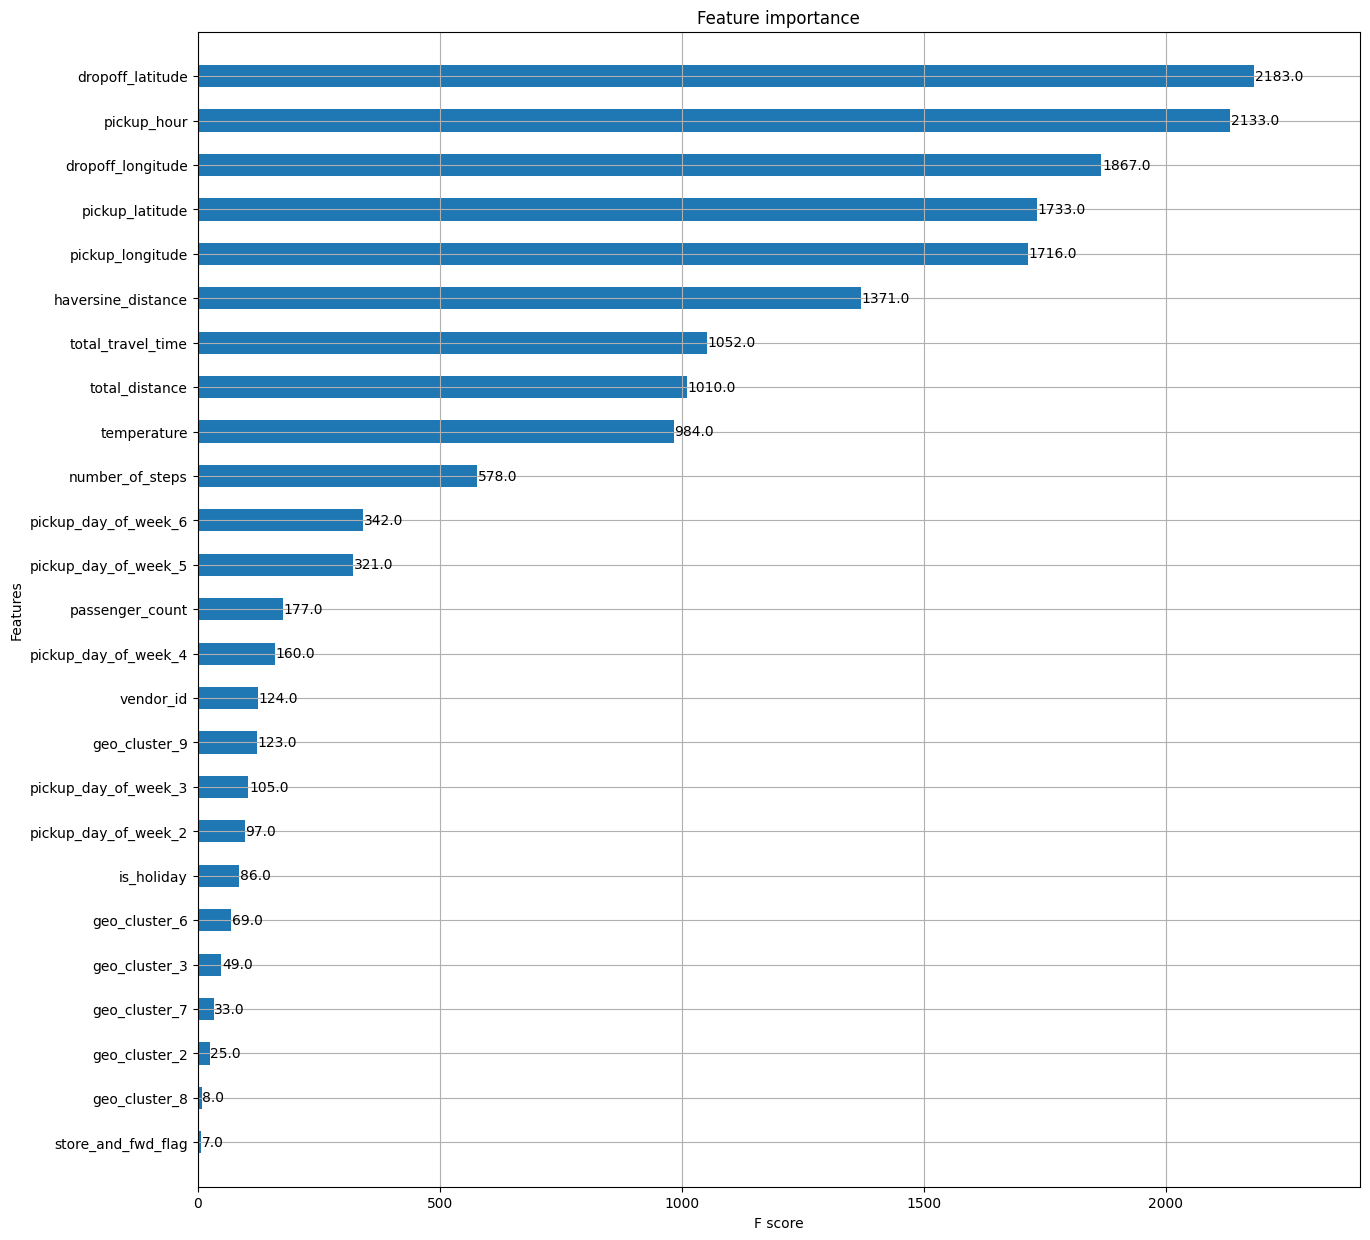

In [217]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)